In [2]:
# Import libraries/packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
from pathlib import Path

In [ ]:
# Load fuel_data_raw_anon.csv file
ROOT = Path.cwd().parent
fuel_data_raw = pd.read_csv(ROOT / 'data/raw/fuel_data_raw_anon.csv')
fuel_data_raw['Delivery_Date'] = pd.to_datetime(fuel_data_raw['Delivery_Date'])

In [4]:
fuel_data_raw.head(5)

,Delivery_ID,Origin_ID,Destination_ID,Truck_Tank_Capacity_Liters,Product,Delivered_Volume_Liters,Product_Storage_Capacity_Liters,Previous_Delivery_Date,Delivery_Date,Tractor,Trailer,Distance_km
0,56660,Source_1,Station_1,11365.0,Product_1,6781.0,20441.38,2022-12-24,2023-01-02,NaN,Trailer_1,52.544
1,56852,Source_1,Station_1,12728.8,Product_1,4912.0,20441.38,2023-01-02,2023-01-05,NaN,Trailer_2,52.544
2,56995,Source_1,Station_1,20003.0,Product_1,7467.0,20441.38,2023-01-05,2023-01-07,NaN,Trailer_3,52.544
3,57252,Source_1,Station_1,12728.8,Product_1,4941.0,20441.38,2023-01-07,2023-01-11,NaN,Trailer_2,52.544
4,57352,Source_1,Station_1,11365.0,Product_1,4498.0,20441.38,2023-01-11,2023-01-13,NaN,Trailer_1,52.544


#### Summary of Dataset Characteristics

In [ ]:
# Create summary statistics for the anonymized dataset
summary_stats = {
    "Total Samples": len(fuel_data_raw),
    "Date Range": f"{fuel_data_raw['Delivery_Date'].min().date()} to {fuel_data_raw['Delivery_Date'].max().date()}",
    "Unique Trailers": fuel_data_raw['Trailer'].nunique(),
    "Unique Tractors": fuel_data_raw['Tractor'].nunique(),
    "Unique Stations": fuel_data_raw['Destination_ID'].nunique(),
    "Unique Depots": fuel_data_raw['Origin_ID'].nunique(),
    "Unique Products": fuel_data_raw['Product'].nunique()
}

summary_df = pd.DataFrame(list(summary_stats.items()), columns=["Metric", "Value"])

summary_df.head(10)


,Metric,Value
0,Total Samples,39629
1,Date Range,2023-01-01 to 2025-05-31
2,Unique Trailers,64
3,Unique Tractors,51
4,Unique Stations,25
5,Unique Depots,3
6,Unique Products,4


In [6]:
fuel_data_raw.drop(['Delivery_ID', 'Delivery_Date'], axis=1).describe()

,Truck_Tank_Capacity_Liters,Delivered_Volume_Liters,Product_Storage_Capacity_Liters,Distance_km
count,39629.000000,39629.000000,39629.000000,39629.000000
mean,32944.142234,13017.031577,42319.819778,34.031564
std,10685.882874,7537.793312,23730.406826,18.725891
min,11365.000000,10.000000,2044.140000,0.894000
25%,27598.770000,7050.000000,34068.970000,16.226000
50%,36368.000000,12079.000000,34068.970000,33.010000
75%,41400.420000,17719.000000,61324.140000,49.170000
max,43187.000000,43734.000000,136275.880000,77.853000


#### Number of Deliveries per Source Depot

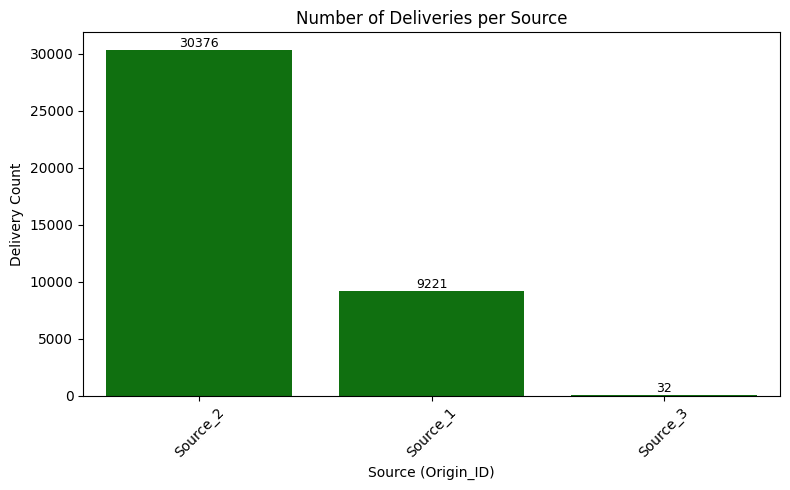

In [6]:
# Count of deliveries for each Source (Origin_ID)
deliveries_per_source = fuel_data_raw['Origin_ID'].value_counts().reset_index()
deliveries_per_source.columns = ['Origin_ID', 'Delivery_Count']

# Visualize as bar plot
plt.figure(figsize=(8, 5))
ax = sns.barplot(data=deliveries_per_source, x='Origin_ID', y='Delivery_Count', color='green')
plt.title('Number of Deliveries per Source')
plt.xlabel('Source (Origin_ID)')
plt.ylabel('Delivery Count')
plt.xticks(rotation=45)
plt.tight_layout()

# Add value labels
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{int(height)}', 
                (p.get_x() + p.get_width() / 2., height),
                ha='center', va='bottom', fontsize=9)

plt.show()


#### Distribution of Trailers by Truck Tank Capacity Group

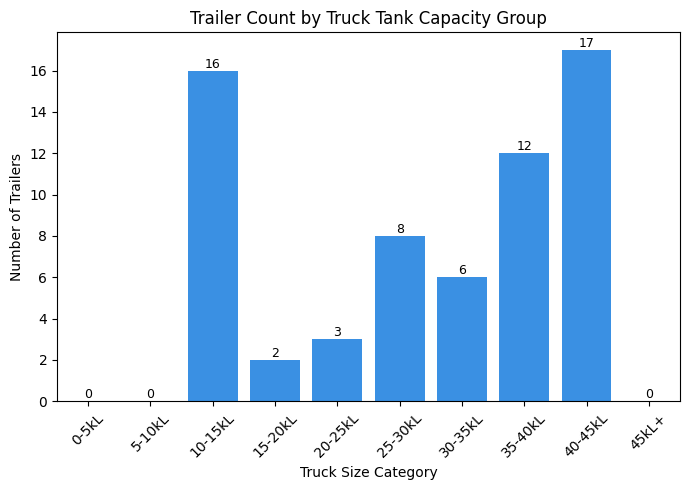

In [9]:
# Categorize Truck Tank Capacity and count quantity in each group
bins = [0, 5000, 10000, 15000, 20000, 25000, 30000, 35000, 40000, 45000, np.inf]
labels = [
    '0-5kL', '5-10kL', '10-15kL', '15-20kL', '20-25kL', 
    '25-30kL', '30-35kL', '35-40kL', '40-45kL', '45kL+'
]

# Count the number of unique trucks (trailers) in each capacity group
truck_capacity = fuel_data_raw[['Trailer', 'Truck_Tank_Capacity_Liters']].drop_duplicates()
truck_capacity['Truck_Size'] = pd.cut(truck_capacity['Truck_Tank_Capacity_Liters'], bins=bins, labels=labels)
truck_size_counts = truck_capacity['Truck_Size'].value_counts().sort_index().reset_index()
truck_size_counts.columns = ['Truck_Size', 'Count']

# Plot the number of unique trailers per truck size
plt.figure(figsize=(7, 5))
ax = sns.barplot(data=truck_size_counts, x='Truck_Size', y='Count', color='dodgerblue')
plt.title('Trailer Count by Truck Tank Capacity Group')
plt.xlabel('Truck Size Category')
plt.ylabel('Number of Trailers')
plt.xticks(rotation=45)
plt.tight_layout()

# Add value labels
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{int(height)}', 
                (p.get_x() + p.get_width() / 2., height),
                ha='center', va='bottom', fontsize=9)

plt.show()

#### Truck Type Summary

In [ ]:
# Classify Truck Types
fuel_data_raw['Truck_Type'] = fuel_data_raw['Truck_Tank_Capacity_Liters'].apply(
    lambda cap: 'Small' if cap < 18000 else ('Medium' if cap < 30000 else 'Large')
)

# Ensure delivery date is datetime
fuel_data_raw['Delivery_Date'] = pd.to_datetime(fuel_data_raw['Delivery_Date'])

# Trips per Trailer per Day
trips_by_day = fuel_data_raw.groupby(['Trailer', 'Delivery_Date']).size().reset_index(name='Trips')

# Map Truck Type to Trailer
trailer_types = fuel_data_raw[['Trailer', 'Truck_Type']].drop_duplicates()
trips_by_day = trips_by_day.merge(trailer_types, on='Trailer', how='left')

# Summary of Trips
trips_summary = (
    trips_by_day.groupby('Truck_Type')['Trips']
    .agg(Avg_Trips_Per_Day='mean', Max_Trips_Per_Day='max')
    .reset_index()
)

# Calculate Round-Trip Distance
fuel_data_raw['RoundTrip_Distance_km'] = fuel_data_raw['Distance_km'] * 2
distance_by_day = (
    fuel_data_raw.groupby(['Trailer', 'Delivery_Date'])['RoundTrip_Distance_km']
    .sum()
    .reset_index()
)

# Map Truck Type Again
distance_by_day = distance_by_day.merge(trailer_types, on='Trailer', how='left')

# Summary of Distances
distance_summary = (
    distance_by_day.groupby('Truck_Type')['RoundTrip_Distance_km']
    .agg(
        Avg_Distance_Travelled_Per_Day_km='mean',
        Max_Distance_Travelled_Per_Day_km='max'
    )
    .reset_index()
)

# Merge Final Summary
truck_type_summary = trips_summary.merge(distance_summary, on='Truck_Type')

truck_type_summary = truck_type_summary.set_index('Truck_Type').reindex(['Small', 'Medium', 'Large']).dropna().reset_index()
numeric_cols = truck_type_summary.select_dtypes(include='number').columns
truck_type_summary[numeric_cols] = truck_type_summary[numeric_cols].round(2)

truck_type_summary.head(10)

,Truck_Type,Avg_Trips_Per_Day,Max_Trips_Per_Day,Avg_Distance_Travelled_Per_Day_km,Max_Distance_Travelled_Per_Day_km
0,Small,1.40,4,76.13,374.46
1,Medium,2.58,11,185.13,878.46
2,Large,3.01,11,212.16,947.76


#### Distribution of Trailer Availability Percentages Over the Delivery Period

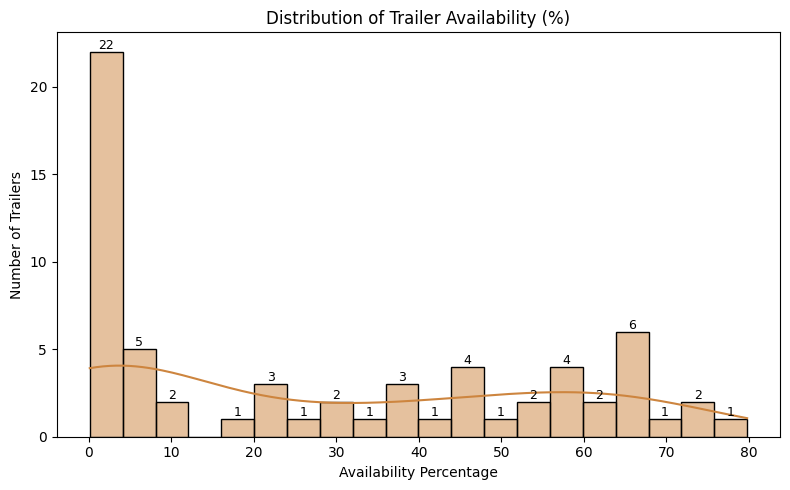

In [ ]:
# Total number of unique days in the dataset
total_days = (fuel_data_raw['Delivery_Date'].max() - fuel_data_raw['Delivery_Date'].min()).days + 1

# Count the number of unique delivery days per trailer
trailer_day_counts = (
    fuel_data_raw
    .groupby('Trailer')['Delivery_Date']
    .nunique()
    .reset_index(name='Active_Days')
)

# Calculate availability as a percentage of total days
trailer_day_counts['Availability_Percent'] = (trailer_day_counts['Active_Days'] / total_days) * 100

# Get unique trailer and tank capacity combinations
truck_sample = fuel_data_raw[['Trailer', 'Truck_Tank_Capacity_Liters']].drop_duplicates()

# Merge with availability data
truck_sample = pd.merge(truck_sample, trailer_day_counts, on='Trailer', how='left')

# Fill any missing availability values with 0 and round to 2 decimals
truck_sample['Availability_Percent'] = truck_sample['Availability_Percent'].fillna(0).round(2)

# Plot Histogram of Availability Percent
plt.figure(figsize=(8, 5))
ax = sns.histplot(
    truck_sample['Availability_Percent'], 
    bins=20, 
    kde=True, 
    color='peru'
)
plt.title('Distribution of Trailer Availability (%)')
plt.xlabel('Availability Percentage')
plt.ylabel('Number of Trailers')
plt.tight_layout()

# Add value labels on top of each histogram bar
for patch in ax.patches:
    height = patch.get_height()
    if height > 0:
        ax.annotate(f'{int(height)}', 
                    (patch.get_x() + patch.get_width() / 2., height),
                    ha='center', va='bottom', fontsize=9)

plt.show()

#### Average Monthly Fuel Demand by Station and Product

<Figure size 1200x600 with 0 Axes>

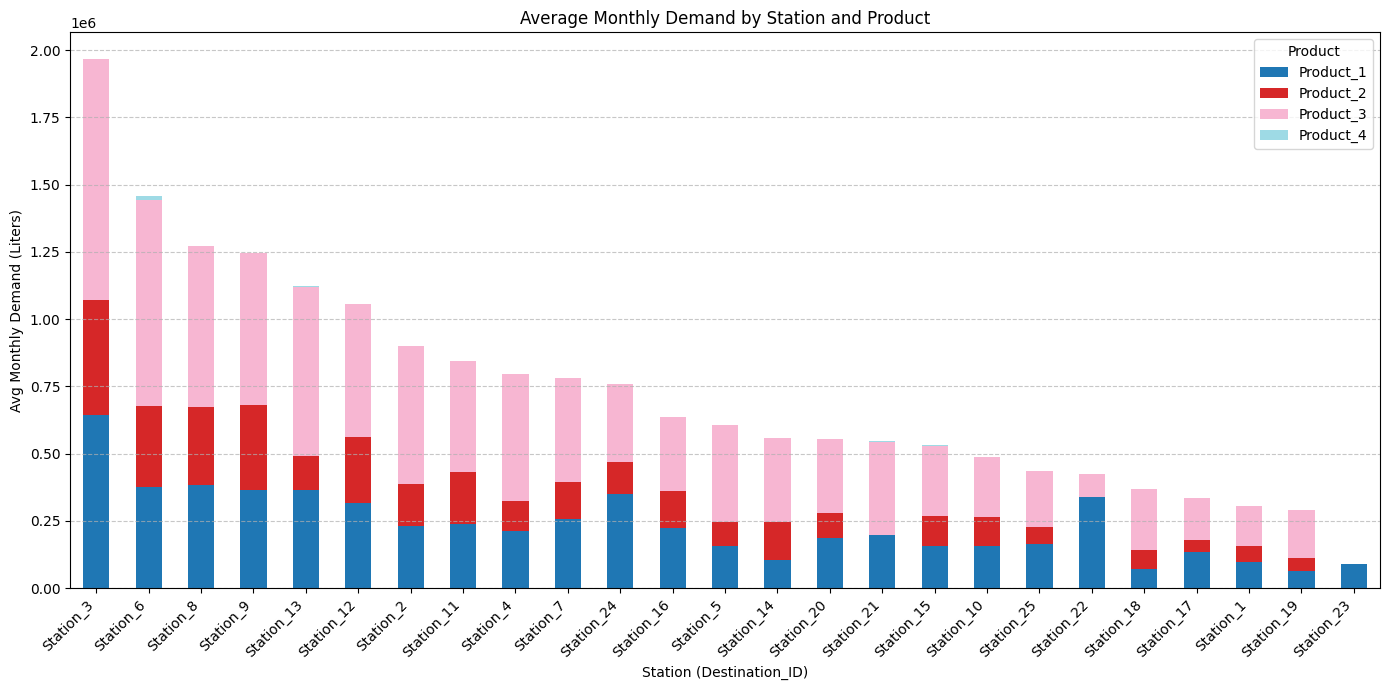

In [12]:
# Calculate monthly demand per station and product
monthly_demand = (
    fuel_data_raw.groupby(['Destination_ID', 'Product', pd.Grouper(key='Delivery_Date', freq='ME')])['Delivered_Volume_Liters']
    .sum()
    .reset_index()
)

# Calculate average monthly demand by station and product
avg_monthly_demand = (
    monthly_demand.groupby(['Destination_ID', 'Product'])['Delivered_Volume_Liters']
    .mean()
    .reset_index(name='Avg_Monthly_Demand_Liters')
)

# Pivot data for stacked bar chart
pivot_data = avg_monthly_demand.pivot(index='Destination_ID', columns='Product', values='Avg_Monthly_Demand_Liters').fillna(0)
pivot_data['Total'] = pivot_data.sum(axis=1)

# Sort the pivot data by total demand
pivot_data_sorted = pivot_data.sort_values(by='Total', ascending=False).drop(columns='Total')

# Plot stacked bar chart in descending order
plt.figure(figsize=(12, 6))
pivot_data_sorted.plot(kind='bar', stacked=True, figsize=(14, 7), colormap='tab20')
plt.title('Average Monthly Demand by Station and Product')
plt.xlabel('Station (Destination_ID)')
plt.ylabel('Avg Monthly Demand (Liters)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Product', loc='upper right', frameon=True)
plt.show()

#### Round-Trip Distance from Source Depot to Each Station

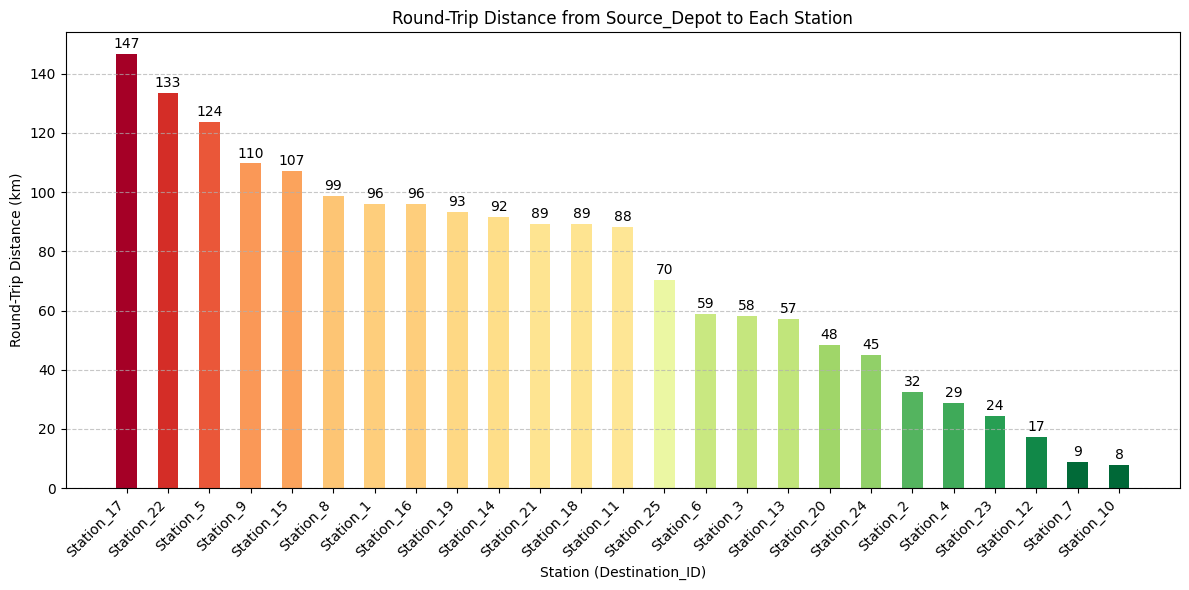

In [13]:
# Filter for Source_2 deliveries
source2_data = fuel_data_raw[fuel_data_raw['Origin_ID'] == 'Source_2'].copy()

# Rename for consistency
source2_data['Origin_ID'] = 'Source_Depot'

# Take the first distance value per station as the standard (assumes consistent routing)
station_distances = (
    source2_data[['Destination_ID', 'Distance_km']]
    .drop_duplicates()
    .groupby('Destination_ID')['Distance_km']
    .first()
    .reset_index()
)

# Calculate round-trip distance
station_distances['RoundTrip_Distance_km'] = station_distances['Distance_km'] * 2

# Sort by distance for better visualization
station_distances = station_distances.sort_values(by='RoundTrip_Distance_km', ascending=False)

# Plot
# Reverse the red-to-green gradient by flipping the colormap
values = station_distances['RoundTrip_Distance_km']
norm = plt.Normalize(values.min(), values.max())
cmap = plt.colormaps.get_cmap('RdYlGn_r')
reversed_colors = cmap(norm(values))

# Plot with flipped color gradient
plt.figure(figsize=(12, 6))
bars = plt.bar(
    station_distances['Destination_ID'],
    values,
    width=0.5,
    color=reversed_colors
)

# Add value labels above bars
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height + 1,
        f'{height:.0f}',
        ha='center',
        va='bottom',
        rotation=0
    )

plt.title('Round-Trip Distance from Source_Depot to Each Station')
plt.xlabel('Station (Destination_ID)')
plt.ylabel('Round-Trip Distance (km)')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
